In [1]:
"""
Intersect 2011 Thai flood depth raster (courtesy of JBA) with WRI powerplant point locations
Ballpark estimate of rehabilitation costs...
"""

'\nIntersect 2011 Thai flood depth raster (courtesy of JBA) with WRI powerplant point locations\nBallpark estimate of rehabilitation costs...\n'

In [11]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rasterstats
import shapely
import snail.damages, snail.intersection

In [3]:
raster_path = "data/TH_FLRF_ChaoPhraya2011_RD_01.tif"
powerplants_path = "data/powerplants.geoparquet"
damage_curve_path = "damage_curve.csv"

# read raster
raster = rasterio.open(raster_path)
grid = snail.intersection.GridDefinition.from_raster(raster_path)
minx, miny, maxx, maxy = raster.bounds
raster_values = raster.read().squeeze()  # squeeze to drop leading size 1 dim

# read powerplants
global_pp = gpd.read_parquet(powerplants_path).drop(columns=["estimated_generation_gwh_2017", "asset_type"])
thai_pp = global_pp.cx[minx: maxx, miny: maxy]

In [4]:
# there is a powerplant that is listed as flooded in the PDNA, on the Rojana industrial estate
# there is some confusion as to its installed capacity

# its own website lists the capacity as 275MW: http://www.rojanapower.com/#
# the PDNA says 280MW: https://www.gfdrr.org/sites/default/files/publication/Thai_Flood_2011_2.pdf
# this website says 316MW: https://www.power-technology.com/data-insights/power-plant-profile-rojana-combined-cycle-power-plant-thailand/
# the business park it's located on lists: 265 + 430 = 695MW: https://www.rojana.com/rojanaproject/0-1-AYUTTHAYA
# WRI has the capacity at 1600MW...

# we choose to use the PDNA figure here
row = thai_pp[thai_pp.name.str.contains("Rojana")].index
thai_pp.loc[row, "power_mw"] = 280

In [5]:
# extract depths at powerplant points
point_depth = rasterstats.point_query(thai_pp.geometry, raster_path)

# extract maximum depths within buffer of powerplant points
buffer_radius_m = 250  # 1 arcsec / px is approx 30 m / px
projected_crs = thai_pp.estimate_utm_crs()
buffered_points = thai_pp.geometry.to_crs(projected_crs).buffer(buffer_radius_m).to_crs(4326)
buffered_depth = rasterstats.zonal_stats(buffered_points, raster_path)
max_buffered_depth = [location["max"] for location in buffered_depth]
depths = pd.DataFrame(
    index=thai_pp.index,
    data={
        "point_depth_m": point_depth,
        "max_buffered_depth_m": max_buffered_depth
    }
).fillna(0)

In [6]:
# calculate damage fractions from depths for point and buffered figures
curve = snail.damages.PiecewiseLinearDamageCurve.from_csv(
    damage_curve_path,
    intensity_col="depth_m",
    damage_col="damage_fraction"
)
damages = thai_pp.join(depths, how="inner")
damages["damage_ratio_point"] = curve.damage_fraction(damages.point_depth_m)
damages["damage_ratio_buffer"] = curve.damage_fraction(damages.max_buffered_depth_m)

# top plants by damage
damages.sort_values("damage_ratio_buffer", ascending=False).head(10)

# https://www.gfdrr.org/sites/default/files/publication/Thai_Flood_2011_2.pdf
# page 120 for reported flooding to power plants:
# ... The privately owned 280MW combined-cycle power plant in Rojana Industrial Park was flooded in the
# third week of October and remained flooded at the time of the team’s field visit on 15 November, 2011.
# ... the damage to the Rojana power plant is estimated at THB 2.4 billion.
# 
# ... that's about $65M
#
# however... the JBA flood map does not show significant flooding of the facility,
# so no damage for us (certainly not with the unbuffered point)...

,name,source_id,power_mw,primary_fuel,geometry,point_depth_m,max_buffered_depth_m,damage_ratio_point,damage_ratio_buffer
21557,Nakhon Sawan Solar Power Plant,WRI1026244,1.0,Solar,POINT (100.11860 15.73860),3.273534,5.294466,0.300000,0.300000
21486,EGCO Cogen,WRI1019467,112.0,Gas,POINT (100.57270 14.09770),3.881643,3.963405,0.300000,0.300000
21455,Ang Thong Solar Power Plant,WRI1026223,1.2,Solar,POINT (100.47610 14.58940),4.150415,4.484148,0.300000,0.300000
21642,Wang Noi,WRI1000169,2027.0,Gas,POINT (100.78050 14.23240),0.000000,3.023115,0.000000,0.295698
21598,Sai Yoi Solar Power Plant,WRI1026310,3.0,Solar,POINT (100.19540 13.98420),0.000000,2.566649,0.000000,0.210332
21591,Sai Prapa Solar Power Plant,WRI1026303,7.2,Solar,POINT (100.20020 13.99990),2.566649,2.566649,0.210332,0.210332
21476,Chachoengsao Solar Power Plant,WRI1026234,1.3,Solar,POINT (101.00300 13.57580),1.088084,2.144973,0.089047,0.175598
21639,Wang Luek Solar Power Plant,WRI1026334,8.0,Solar,POINT (100.13310 14.73910),2.131103,2.131103,0.174488,0.174488
21594,Sai Tatong Solar Power Plant,WRI1026306,1.0,Solar,POINT (100.12800 14.24400),0.886893,2.039526,0.072951,0.167162
21461,Bang Ban Solar Power Plant,WRI1026227,7.0,Solar,POINT (100.48100 14.44180),2.020436,2.021334,0.165635,0.165707


In [9]:
# US power plant construction costs
# https://www.eia.gov/electricity/generatorcosts/xls/generator_costs_2021.xlsx
# e.g. for gas...
# 920 [USD 2021] / capacity [kW]
# 920000 [USD 2021] / capacity [MW]
# N.B. not deflated to 2011, and no accounting for learning effects between 2011 and 2021

construction_cost_usd_per_mw = {
    "Biomass": 2592000,
    "Gas": 920000,
    "Solar": 1561000,
    "Wind": 1428000,
}
damages["construction_cost"] = damages.apply(lambda row: construction_cost_usd_per_mw[row.primary_fuel] * row.power_mw, axis=1)
damages["rehab_cost_point"] = damages.damage_ratio_point * damages.construction_cost
damages["rehab_cost_buffer"] = damages.damage_ratio_buffer * damages.construction_cost

damages.sort_values("rehab_cost_buffer", ascending=False).head(10)

,name,source_id,power_mw,primary_fuel,geometry,point_depth_m,max_buffered_depth_m,damage_ratio_point,damage_ratio_buffer,construction_cost,rehab_cost_point,rehab_cost_buffer
21642,Wang Noi,WRI1000169,2027.0,Gas,POINT (100.78050 14.23240),0.000000,3.023115,0.000000,0.295698,1.864840e+09,0.000000e+00,5.514303e+08
21486,EGCO Cogen,WRI1019467,112.0,Gas,POINT (100.57270 14.09770),3.881643,3.963405,0.300000,0.300000,1.030400e+08,3.091200e+07,3.091200e+07
21462,Bang Bo,WRI1019483,350.0,Gas,POINT (100.84160 13.49200),0.872301,0.902562,0.071784,0.074205,3.220000e+08,2.311447e+07,2.389399e+07
21590,Sai Phet Solar Power Plant,WRI1026302,35.9,Solar,POINT (100.17440 14.10780),0.000000,1.907032,0.000000,0.156563,5.603990e+07,0.000000e+00,8.773750e+06
21573,Phitsanulok Solar Power Plant,WRI1026299,90.0,Solar,POINT (100.11800 17.07130),0.000000,0.648411,0.000000,0.052873,1.404900e+08,0.000000e+00,7.428109e+06
21596,Sai Yai - Solarco Solar Power Plant,WRI1026308,23.8,Solar,POINT (100.14320 14.13680),0.000000,1.907032,0.000000,0.156563,3.715180e+07,0.000000e+00,5.816581e+06
21466,Bangchak III,WKS0063636,25.0,Solar,POINT (100.55300 14.16900),0.000000,1.010171,0.000000,0.082814,3.902500e+07,0.000000e+00,3.231805e+06
21589,Sai Kyo Solar Power Plant,WRI1026301,11.9,Solar,POINT (100.13770 14.15420),1.838370,1.907032,0.151070,0.156563,1.857590e+07,2.806254e+06,2.908290e+06
21456,B Grimm BIP,WRI1019488,230.0,Gas,POINT (100.56490 13.97450),0.148729,0.148729,0.011898,0.011898,2.116000e+08,2.517682e+06,2.517682e+06
21597,Sai Yai - Solarta Solar Power Plant,WRI1026309,9.7,Solar,POINT (100.15060 14.13850),0.000000,1.907032,0.000000,0.156563,1.514170e+07,0.000000e+00,2.370623e+06


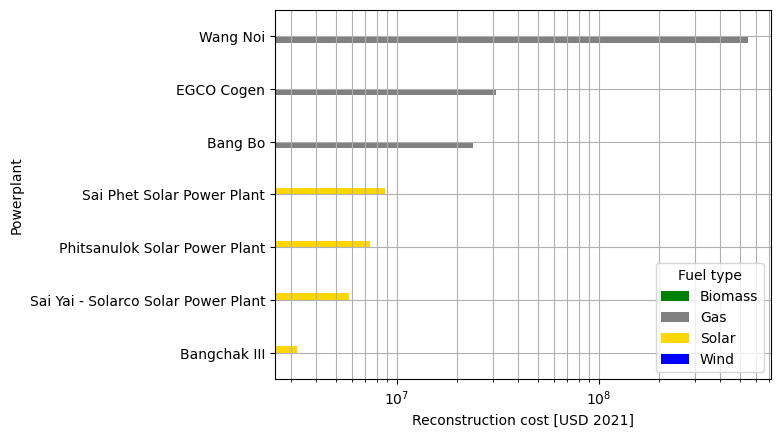

In [24]:
to_plot = damages[["primary_fuel", "name", "rehab_cost_buffer"]].groupby(["primary_fuel", "name"]).sum().unstack("primary_fuel")
to_plot = to_plot.fillna(0)
to_plot.columns = to_plot.columns.droplevel()
to_plot.columns.name = "Fuel type"

# order by reconstruction cost
to_plot["temp"] = to_plot.apply(max, axis=1)
to_plot = to_plot.sort_values("temp").drop(columns=["temp"])

f, ax = plt.subplots()
subset = to_plot[to_plot > 3E6]
subset.dropna(how="all").plot.barh(
    ax=ax,
    color={"Gas": "grey", "Solar": "gold", "Wind": "blue", "Biomass": "green"}
)
ax.set_xscale("log")
ax.set_ylabel("Powerplant")
ax.set_xlabel("Reconstruction cost [USD 2021]")
ax.grid(which="both")